In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests

# load the processor
processor = AutoProcessor.from_pretrained(
    'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto',
    use_fast=True
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    'allenai/Molmo-7B-D-0924',
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

/scr/kimkj/miniconda3/envs/molmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- image_preprocessing_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- preprocessing_molmo.py
- image_preprocessing_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.
A new version

In [14]:
import cv2 as cv
import os
from PIL import Image
print("Saving frames to:", os.getcwd())
video = '/media/kimkj/data/kimkj/expdata/libero/im/bc_xfmr/04-20-FINETUNE-STRAP-IMG-STRAP-IMG-kitchen_scene3_turn_on_the_stove_and_put_the_moka_pot_on_it/123/04-20-FT-STRAP-IMG-STRAP-IMG-kitchen_scene3_turn_on_the_stove_and_put_the_moka_pot_on_it/videos/KITCHEN_SCENE3_turn_on_the_stove_and_put_the_moka_pot_on_it_epoch_150.mp4'
cap = cv.VideoCapture(video)
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# 'ret' is a boolean value that indicates whether the frame was successfully read from the video capture object.
ret, frame = cap.read()
if ret:
    cv.imwrite("0.jpg", frame)
    file = os.path.join(os.getcwd(), "0.jpg")
else:
    print("Error: Could not read the first frame.")


cap.release()
cv.destroyAllWindows()


Saving frames to: /home/kimkj/Documents/molmo-handtracker/modules/robot_learning/robot_learning/notebooks


In [15]:
image = Image.open(file).convert("RGB")

In [17]:
# process the image and text
inputs = processor.process(
    images=[image],
    text="Point to the center of the robot hand."
)

# move inputs to the correct device and make a batch of size 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=50, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
)

# only get generated tokens; decode them to text
generated_tokens = output[0, inputs["input_ids"].size(1) :]
generated_text = processor.tokenizer.decode(
    generated_tokens, skip_special_tokens=True
)

# print(inputs.keys())

# print the generated text
print(generated_text)
# print(scaled_parsed_points)

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 2 has a total capacity of 5.92 GiB of which 86.19 MiB is free. Including non-PyTorch memory, this process has 5.01 GiB memory in use. Of the allocated memory 4.92 GiB is allocated by PyTorch, and 12.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [37]:
import re
from PIL import ImageDraw

def parse_points(input_string):
    """
    Parses points from the input string, assuming the points are percentages of the image size.

    Parameters:
    - input_string: XML-like string containing the points as percentages.

    Returns:
    - List of (x, y) tuples in percentage form (0.0 to 1.0).
    """
    pattern = re.compile(r'x="([\d.]+)"\s+y="([\d.]+)"')
    points = [
        [float(match[0]) / 100, float(match[1]) / 100]
        for match in pattern.findall(input_string)
    ]
    return points

def scale_points_to_image(points, image_size):
    """
    Scales percentage-based points to actual pixel coordinates based on the image size.

    Parameters:
    - points: List of (x, y) tuples as percentages of the image size.
    - image_size: Tuple (width, height) of the image.

    Returns:
    - List of scaled (x, y) points in pixel coordinates.
    """
    width, height = image_size
    scaled_points = [[x * width, y * height] for x, y in points]
    return scaled_points


def draw_points_on_image(image, points, point_radius=5, color=(0, 255, 0)):
    """
    Draws points on a PIL image.

    Parameters:
    - image: The PIL image object.
    - points: List of (x, y) tuples representing points to draw.
    - point_radius: Radius of the points (default: 5).
    - color: RGB color of the points (default: red).

    Returns:
    - Image with the points drawn.
    """
    # Create a drawable object
    draw = ImageDraw.Draw(image)

    # Draw each point
    for x, y in points:
        upper_left = (x - point_radius, y - point_radius)
        lower_right = (x + point_radius, y + point_radius)
        draw.ellipse([upper_left, lower_right], fill=color)

    return image

In [38]:
type(generated_text)

str

[[0.586, 0.19]]
[[1125.12, 205.2]]


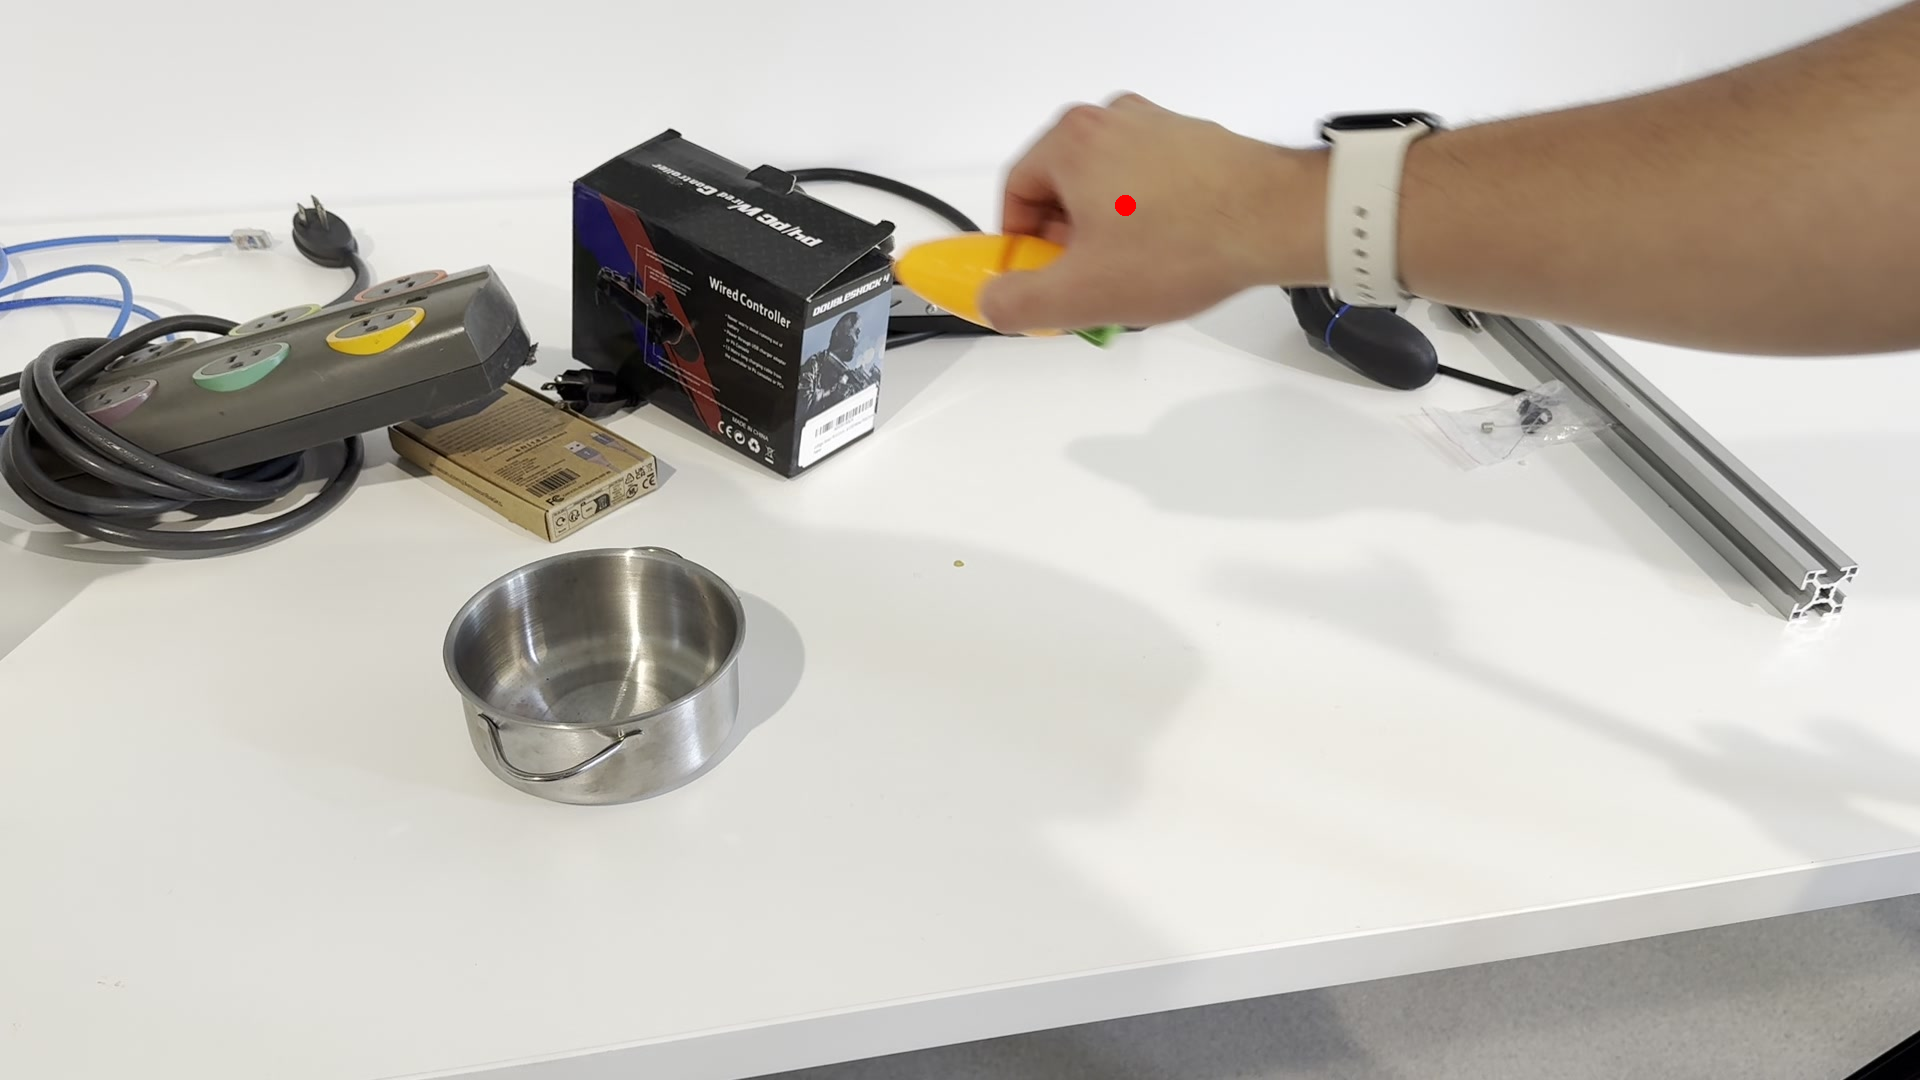

: 

In [40]:
# parse the generated text
parsed_points = parse_points(generated_text)
print(parsed_points)

# scale the points
scaled_parsed_points = scale_points_to_image(parsed_points, image.size)
print(scaled_parsed_points)

import copy
draw_points_on_image(copy.deepcopy(image), scaled_parsed_points, point_radius=10, color=(255, 0, 0))

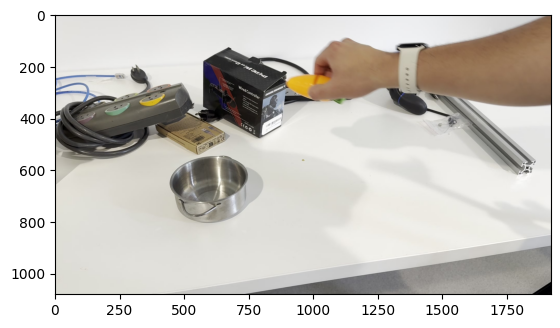

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)

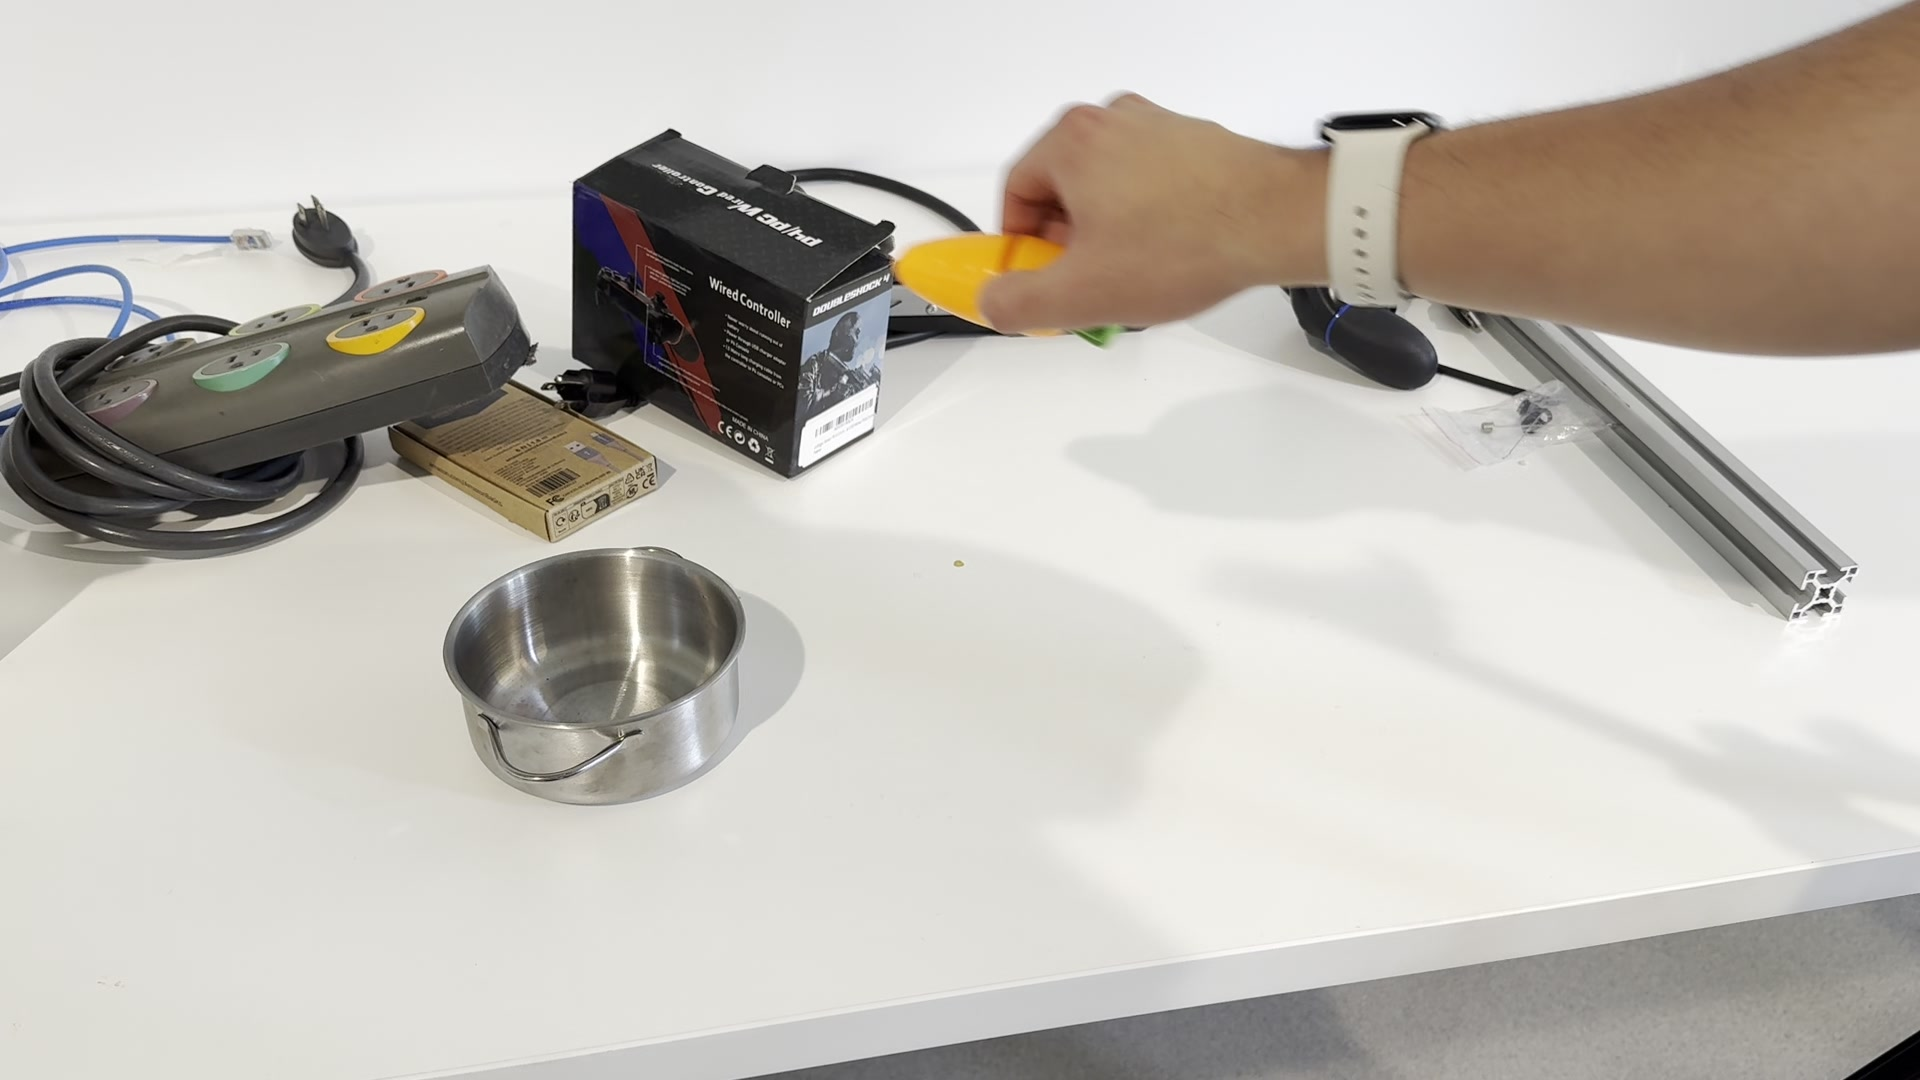

In [10]:
image